In [2]:
import tensorflow
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, BatchNormalization, Input, MaxPooling2D, UpSampling2D
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam, SGD
EarlyStopping = tensorflow.keras.callbacks.EarlyStopping
from matplotlib import pyplot as plt
import numpy as np

Sequential = tensorflow.keras.models.Sequential
from sklearn.model_selection import train_test_split

import sys
import os
print("Num GPUs Available: ", len(tensorflow.config.list_physical_devices('GPU')))
gpus = tensorflow.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tensorflow.config.experimental.set_memory_growth(gpu, True)
        print("GPU is configured and ready to use")
    except RuntimeError as e:
        print("Error configuring GPU:", e)
else:
    print("No GPU found. Using CPU instead.")

Num GPUs Available:  2
GPU is configured and ready to use


In [3]:

# sys.path.append(os.path.abspath('..'))
# sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__file__), '..')))
# from data.data_io import get_data_and_labels
# from data.data_io import get_data_and_labels
def load_boards(filename):
    with np.load(filename) as data:
        print(f'Loading dataset of size {len(data)} from {filename}')
        return [data[key] for key in data]

def get_data_and_labels(xfile, yfile, zfile, coverage_mask_bool=False):
    data = load_boards(xfile)
    labels = load_boards(yfile)
    #coverage_mask = load_boards(zfile)

    #combine data and coverage_mask into shape (x,y,2)
    # if coverage_mask_bool:
    #     data = [np.concatenate((d, c), axis=-1) for d, c in zip(data, coverage_mask)]
    print(f'size {data[0].shape}')

    data = tensorflow.convert_to_tensor(data, dtype=tensorflow.float32)
    labels = tensorflow.convert_to_tensor(labels, dtype=tensorflow.float32)
    return [data, labels]

def accuracy(real, output):
    ans = real.copy()
    for i in range(len(real)):
        for j in range(len(real[0])):
            ans[i][j] = f'r{real[i][j]} o{output[i][j]}'
    return ans

coverage_mask = False

def create_tf_dataset(data, labels, train_split=0.8, batch_size=32):
    dataset = tensorflow.data.Dataset.from_tensor_slices((data, labels))

    # Calculate split sizes
    total_size = len(data)
    train_size = int(train_split * total_size)

    # Shuffle and split
    train_dataset = dataset.take(train_size).shuffle(train_size).batch(batch_size).prefetch(tensorflow.data.AUTOTUNE)
    test_dataset = dataset.skip(train_size).batch(batch_size).prefetch(tensorflow.data.AUTOTUNE)

    return train_dataset, test_dataset

data, labels = get_data_and_labels('/kaggle/input/minesweeper-boards/board_dataset.npz', '/kaggle/input/minesweeper-boards/labels.npz', '/kaggle/input/minesweeper-boards/coverage_mask.npz', coverage_mask)
data = tensorflow.squeeze(data, axis=1)
labels = tensorflow.squeeze(labels, axis=[1, -1])
train, test = create_tf_dataset(data, labels)

# data, labels = get_data_and_labels('../data/board_dataset.npz', '../data/labels.npz')
# x, xtest, y, ytest = train_test_split(data, labels, test_size=0.2, train_size=0.8)
print(f'dshape: {data.shape}, dtype: {data.dtype}')

Loading dataset of size 100000 from /kaggle/input/minesweeper-boards/board_dataset.npz
Loading dataset of size 100000 from /kaggle/input/minesweeper-boards/labels.npz
size (1, 30, 16, 1)
dshape: (100000, 30, 16, 1), dtype: <dtype: 'float32'>


In [ ]:
from tensorflow.keras.layers import Dropout
def build_model():
    board_height, board_width = 30, 16
    model = Sequential([
        Input(shape=(board_height, board_width, 1)),  # Add channel dimension for grayscale input
        Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'),
        #MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
        #MaxPooling2D(pool_size=(2, 2)),
        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),

        Dropout(0.3),
    
    # More Convolutional Layers
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        #BatchNormalization(),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        #BatchNormalization(),
        
        Conv2D(1, kernel_size=(1, 1), activation='sigmoid', padding='same'),
        #MaxPooling2D(pool_size=(2, 2)),
        #Flatten(),
        #Dense(128, activation='sigmoid'),
        #Dense(board_height * board_width, activation='sigmoid'),  # Output probabilities
        #Reshape((board_height, board_width))  # Reshape back to grid
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.01),
        loss=BinaryCrossentropy(),
        metrics=['precision','accuracy', 'recall']
    )

    return model
model = build_model()
print(f'model shape: {model.input_shape}')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

print(f'model shape: {model.input_shape}')
history = model.fit(
    train,
    epochs=99,
    batch_size=64,
    validation_data=test,
    callbacks=[early_stopping],
    verbose=1,
)
import random
from datetime import datetime
model.save(f'/kaggle/working/msmodel{datetime.now().strftime("%H:%M:%S")}.keras')

model shape: (None, 30, 16, 1)
model shape: (None, 30, 16, 1)
Epoch 1/99
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 34s 12ms/step - accuracy: 0.8294 - loss: 0.3745 - precision: 0.6799 - recall: 0.3184 - val_accuracy: 0.8389 - val_loss: 0.3447 - val_precision: 0.7163 - val_recall: 0.3626
Epoch 2/99
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 29s 11ms/step - accuracy: 0.8386 - loss: 0.3456 - precision: 0.7120 - recall: 0.3654 - val_accuracy: 0.8391 - val_loss: 0.3443 - val_precision: 0.7254 - val_recall: 0.3537
Epoch 3/99
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 29s 12ms/step - accuracy: 0.8388 - loss: 0.3450 - precision: 0.7130 - recall: 0.3656 - val_accuracy: 0.8392 - val_loss: 0.3442 - val_precision: 0.7104 - val_recall: 0.3717
Epoch 4/99
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 29s 12ms/step - accuracy: 0.8388 - loss: 0.3449 - precision: 0.7139 - recall: 0.3643 - val_accuracy: 0.8392 - val_loss: 0.3438 - val_precision: 0.7045 - val_recall: 0.3799
Epoch 5/99
1191/2500 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.8390 - loss:

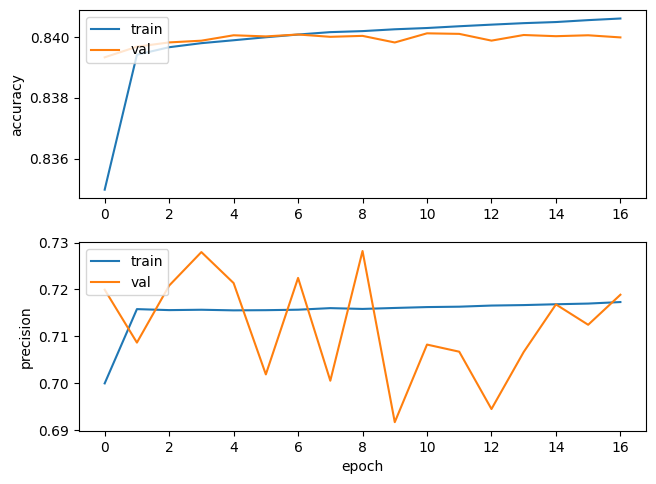

In [9]:
#plot
fig, axs = plt.subplots(2)
fig.tight_layout()

axs[0].plot(history.history['accuracy'])
axs[0].plot(history.history['val_accuracy'])
axs[1].plot(history.history['precision'])
axs[1].plot(history.history['val_precision'])

axs[0].set_ylabel('accuracy')
axs[0].legend(['train', 'val'], loc='upper left')

axs[1].set_ylabel('precision')
axs[1].set_xlabel('epoch')
axs[1].legend(['train', 'val'], loc='upper left')
plt.show()

